In [1]:
!git clone https://github.com/IntelLabs/bayesian-torch
!pip install bayesian-torch/.

Cloning into 'bayesian-torch'...
remote: Enumerating objects: 722, done.
remote: Counting objects: 100% (457/457), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 722 (delta 300), reused 369 (delta 240), pack-reused 265
Receiving objects: 100% (722/722), 277.08 KiB | 2.86 MiB/s, done.
Resolving deltas: 100% (457/457), done.
Processing ./bayesian-torch
  Preparing metadata (setup.py) ... done
  Created wheel for bayesian-torch: filename=bayesian_torch-0.4.0-py3-none-any.whl size=77122 sha256=3267667713d9eb7e366a78fea4422a9952636b5de05ce28220282c80cbb603c5
  Stored in directory: /root/.cache/pip/wheels/c4/64/36/327a5aa82508f440c69defc36b554b49f41c2b5780c95fb461
Successfully built bayesian-torch


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss



import PIL
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(110)


In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters
num_monte_carlo = 20
num_epochs = 100
batch_size = 128
learning_rate = 0.001


In [4]:
simple_trafos = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081,))
])

aug_trafos = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081,))
])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=simple_trafos,
                                           download=True)

train_aug_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=aug_trafos,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          transform=simple_trafos)

test_aug_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          transform=aug_trafos)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

train_aug_loader = torch.utils.data.DataLoader(dataset=train_aug_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

test_aug_loader = torch.utils.data.DataLoader(dataset=test_aug_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 101025697.01it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25817496.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27287327.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15822698.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



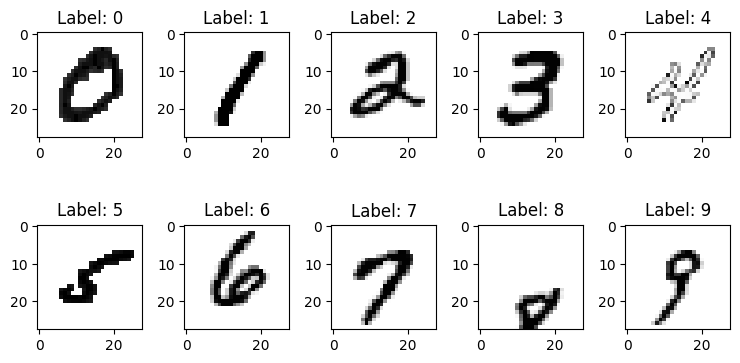

In [5]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i][0], cmap='gray_r')
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_dataset[j][1]:
    j += 1
  images_set.append(train_aug_dataset[j][0])
  labels_set.append(train_aug_dataset[j][1])
plot_set_images(2, 5, images_set, labels_set, "Label: ")

In [6]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

# model = torchvision.models.resnet18(pretrained=True)
# dnn_to_bnn(model, const_bnn_prior_parameters)

In [7]:
from bayesian_torch.utils.util import predictive_entropy, mutual_information
def test(model, test_loader):
  total_acc_test=0
  model.eval()
  with torch.no_grad():
      for i, (X, labels) in enumerate(test_loader):
          X = X.to(device)
          labels = labels.to(device)
          output_mc = []
          for mc_run in range(num_monte_carlo):
                logits = model(X)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                output_mc.append(probs)
          output = torch.stack(output_mc)
          pred_mean = output.mean(dim=0)
          y_pred = torch.argmax(pred_mean, axis=-1)
          total_acc_test += (y_pred.data.cpu().numpy() == labels.data.cpu().numpy()).sum()

  print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
  return total_acc_test / len(test_loader.dataset)


# model = torchvision.models.resnet18(pretrained=False).to(device)
# model.fc = nn.Linear(model.fc.in_features, 10)
# dnn_to_bnn(model, const_bnn_prior_parameters)

# test(model.to(device), test_loader)



In [8]:
def train(model, train_loader, learning_rate, T1=1, T2=1):
  criterion = torch.nn.CrossEntropyLoss()
  model.train()
  learning_rate = 0.01

  for epoch in range(num_epochs):
    if epoch >= 0 and epoch < 30:
                learning_rate = 0.01
    elif epoch >= 30 :
                learning_rate = 0.001


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for i, (images, labels) in (enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        outputs =  model(images).to(device)
        loss1 = criterion(outputs, labels).to(device)
        kl = get_kl_loss(model).to(device)

        loss = ((loss1**(1./T1)) + ((kl / batch_size)**T2)).to(device)
        # print(loss.item())
        losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%5==0:
      print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
      test(model, test_loader)
      test(model, test_aug_loader)
      model.train()
      print()

  return model


In [9]:
T1 = [0.1, 0.2, 0.3, 0.4, 0.5]

print("T=1 and train dataset is clean:")
idx=0
model = torchvision.models.resnet18(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 10)
dnn_to_bnn(model, const_bnn_prior_parameters)
mod = train(model.to(device), train_loader, learning_rate, T1=1, T2=1)

print()
print()

print("train dataset is augmented:")
for t1 in T1 :
    print("")
    print("T = " + str(t1))
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    mod = train(model.to(device), train_aug_loader, learning_rate, T1=t1, T2=1)
    print("-----------------------------------------------------------------------------------")







T=1 and train dataset is clean:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: ignored